In [ ]:
# pip install pandas numpy scikit-learn matplotlib tensorflow

In [1]:
import pandas as pd
import numpy as np
import IPython
import IPython.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, Flatten, Attention
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

In [2]:
# 1. Load the dataset
data = pd.read_csv('./data/BrentOilPricesMerged.csv')

In [3]:
# 2. Preprocess the data
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
data.head()

,Price,neg_oil,neu_oil,pos_oil,compound_oil,neg_war,neu_war,pos_war,compound_war
Date,,,,,,,,,
2023-04-03,84.930000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-04,84.940002,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-05,84.989998,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-06,85.120003,0.000,0.000,0.000,0.0000,0.000,0.776,0.224,0.9866
2023-04-10,84.180000,0.086,0.816,0.098,0.9796,0.144,0.708,0.147,-0.1356


In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,271.0,82.667343,5.567707,71.839996,78.139999,82.739998,86.355000,96.550003
neg_oil,271.0,0.023033,0.024112,0.000000,0.000000,0.017500,0.038271,0.116000
neu_oil,271.0,0.496814,0.361231,0.000000,0.000000,0.604750,0.831000,0.960000
pos_oil,271.0,0.064340,0.055087,0.000000,0.000000,0.062000,0.100667,0.181000
compound_oil,271.0,0.378112,0.429797,-0.955900,0.000000,0.270900,0.950900,0.999900
neg_war,271.0,0.082097,0.071262,0.000000,0.013000,0.073000,0.132375,0.272500
neu_war,271.0,0.802173,0.128576,0.000000,0.773586,0.817200,0.854250,1.000000
pos_war,271.0,0.104691,0.065619,0.000000,0.066000,0.118000,0.139875,0.435000
compound_war,271.0,0.163507,0.595739,-0.999900,-0.357750,0.115525,0.701659,0.986600


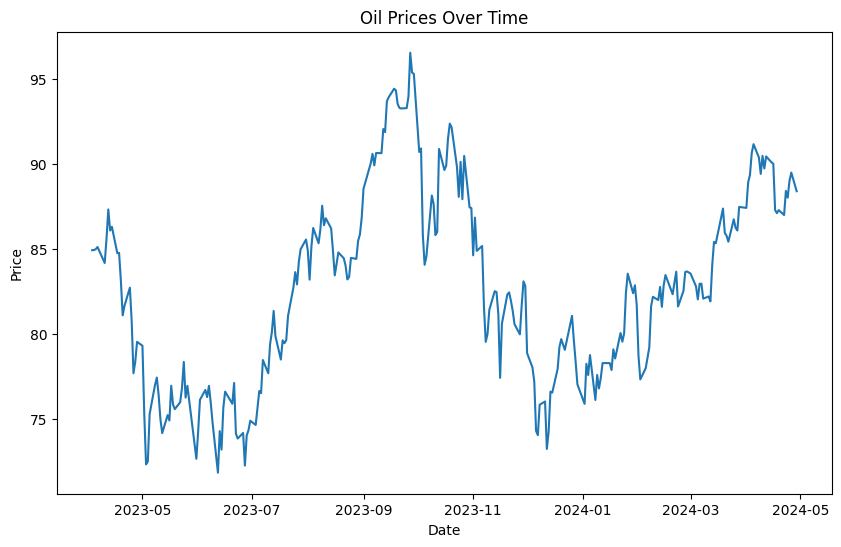

In [6]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Price'])
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [7]:
column_indices = {name: i for i, name in enumerate(data.columns)}
column_indices

{'Price': 0,
 'neg_oil': 1,
 'neu_oil': 2,
 'pos_oil': 3,
 'compound_oil': 4,
 'neg_war': 5,
 'neu_war': 6,
 'pos_war': 7,
 'compound_war': 8}

In [8]:
# Extract the relevant columns for oil sentiment data
# oil_data = data[['Price', 'neg_oil', 'neu_oil', 'pos_oil', 'compound_oil', 'neg_war', 'neu_war', 'pos_war', 'compound_war']]
oil_data = data[['Price']]
oil_data.head()

,Price
Date,
2023-04-03,84.930000
2023-04-04,84.940002
2023-04-05,84.989998
2023-04-06,85.120003
2023-04-10,84.180000


In [9]:
# Normalize the price data
scaler = MinMaxScaler(feature_range=(0, 1))
oil_data['Price'] = scaler.fit_transform(oil_data['Price'].values.reshape(-1, 1))
# oil_data = scaler.fit_transform(oil_data)

C:\Users\wgras\AppData\Local\Temp\ipykernel_20068\1558082071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_data['Price'] = scaler.fit_transform(oil_data['Price'].values.reshape(-1, 1))


In [10]:
n = len(oil_data)
train_df = oil_data[0:int(n*0.7)]
val_df = oil_data[int(n*0.7):int(n*0.875)]
test_df = oil_data[int(n*0.875):]

In [11]:
# train = 70%
# validation = 17.5%
# test - 12.5%

In [12]:
test_df

,Price
Date,
2024-03-12,0.407932
2024-03-13,0.493323
2024-03-14,0.549575
2024-03-15,0.546337
2024-03-18,0.609065
2024-03-19,0.628895
2024-03-20,0.571024
2024-03-21,0.564144
2024-03-22,0.549980


In [13]:
len(train_df),len(val_df),len(test_df)

(189, 48, 34)

In [14]:
train_df.columns

Index(['Price'], dtype='object')

In [15]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [16]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [17]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=1,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def all_data(self):
  return self.make_dataset(oil_data)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.all_data = all_data
WindowGenerator.example = example

In [19]:
val_performance = {}
performance = {}
histories={}
models_list={}
windows_list={}

windows_dictionary = {
    'weekly': 7, 
    'bi-weekly': 14, 
    'monthly': 30,       
}


In [20]:
for w in windows_dictionary:
    input_width=windows_dictionary[w]
    window = WindowGenerator(
        input_width=input_width, label_width=1, shift=1,
        label_columns=['Price']
    )
    windows_list[w]=window

In [21]:
windows_list

{'weekly': Total window size: 8
 Input indices: [0 1 2 3 4 5 6]
 Label indices: [7]
 Label column name(s): ['Price'],
 'bi-weekly': Total window size: 15
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 Label indices: [14]
 Label column name(s): ['Price'],
 'monthly': Total window size: 31
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29]
 Label indices: [30]
 Label column name(s): ['Price']}

In [22]:
windows_list['monthly']

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [23]:
MAX_EPOCHS = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=25)

def compile_and_fit(model, window, patience=4):
  model.compile(
    # loss='mean_absolute_percentage_error',
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer='adam',
    metrics=[
      tf.keras.metrics.MeanAbsolutePercentageError(),
      # tf.keras.metrics.MeanSquaredError()
      tf.keras.metrics.MeanAbsoluteError(),
    ]
  )

  history = model.fit(
    window.train, 
    epochs=MAX_EPOCHS, 
    validation_data=window.val,
    callbacks=[early_stopping,reduce_lr]
  )

  return history

1. Linear model

In [24]:
train_df.shape

(189, 1)

In [25]:
window=windows_list['monthly']
seq_length=30
input_shape=(seq_length, train_df.shape[1])
window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [26]:
input_shape

(30, 1)

In [27]:
def get_transformer_model_1(input_shape, num_heads=4, ff_dim=128, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = MultiHeadAttention(key_dim=ff_dim, num_heads=num_heads)(inputs, inputs)
    x = Dropout(dropout_rate)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [28]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'd_model': self.d_model,
        })
        return config

    def call(self, inputs):
        position = tf.range(tf.shape(inputs)[1], dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(tf.range(0, self.d_model, 2, dtype=tf.float32) * -(np.log(10000.0) / self.d_model))
        angle_rads = position * div_term
        sines = tf.sin(angle_rads)
        cosines = tf.cos(angle_rads)
        pos_encoding = tf.concat([sines, cosines], axis=-1)[tf.newaxis, ...]

        return inputs + pos_encoding

# Transformer with Stacked Encoder Layers
def transformer_encoder(x, num_heads, ff_dim, dropout_rate=0.1):
    # Multi-Head Attention
    attn_output = MultiHeadAttention(key_dim=ff_dim, num_heads=num_heads)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
    
    # Feed Forward Network
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(x.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    
def get_tuned_transformer_model(input_shape, num_heads=16, ff_dim=512, dropout_rate=0.1, num_layers=4):
    inputs = Input(shape=input_shape)
    x = PositionalEncoding(input_shape[-1])(inputs)
    for _ in range(num_layers):
        x = transformer_encoder(x, num_heads, ff_dim, dropout_rate)
    x = Flatten()(x)
    x = Dense(200, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [29]:
# d_model = 4
# num_heads = 4
# ff_dim = 20
# num_transformer_blocks = 32
# dropout_rate = 0.1    

model=get_tuned_transformer_model(input_shape)

In [30]:
history = compile_and_fit(model, window)

histories_Linear = history
val_performance_Linear = model.evaluate(window.val, return_dict=True)
performance_Linear = model.evaluate(window.test, verbose=1, return_dict=True)

Epoch 1/100
159/159 [==============================] - 16s 58ms/step - loss: 0.0341 - mean_absolute_percentage_error: 204996.9688 - mean_absolute_error: 0.1390 - val_loss: 0.0487 - val_mean_absolute_percentage_error: 49.0753 - val_mean_absolute_error: 0.2189 - lr: 0.0010
Epoch 2/100
159/159 [==============================] - 8s 51ms/step - loss: 0.0177 - mean_absolute_percentage_error: 1287901.2500 - mean_absolute_error: 0.1112 - val_loss: 0.0572 - val_mean_absolute_percentage_error: 53.2770 - val_mean_absolute_error: 0.2375 - lr: 0.0010
Epoch 3/100
159/159 [==============================] - 9s 58ms/step - loss: 0.0179 - mean_absolute_percentage_error: 1339159.3750 - mean_absolute_error: 0.1110 - val_loss: 0.0411 - val_mean_absolute_percentage_error: 44.9892 - val_mean_absolute_error: 0.2008 - lr: 0.0010
Epoch 4/100
159/159 [==============================] - 9s 59ms/step - loss: 0.0182 - mean_absolute_percentage_error: 880003.6250 - mean_absolute_error: 0.1123 - val_loss: 0.0187 - val_

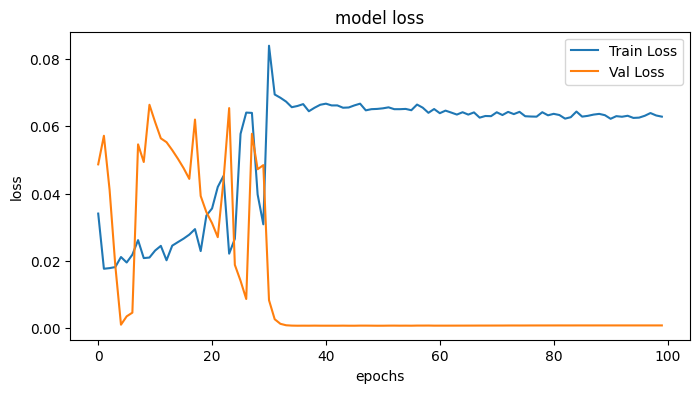

In [31]:
# Plot Train vs Test Loss
plt.figure(figsize=(8,4))
plt.plot(histories_Linear.history['loss'], label='Train Loss')
plt.plot(histories_Linear.history['val_loss'], label='Val Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
# plt.savefig('outputs/reddit oil + war - lstm model 01 model loss.png')
plt.show()

In [32]:
all_predict = model.predict(window.all_data)
all_predict

241/241 [==============================] - 5s 18ms/step


array([[0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.44280094],
       [0.442

In [33]:
all_predict.shape

(241, 1)

In [34]:
X_all_data = scaler.inverse_transform(all_predict)
# Y_test = np.array([s[1][0][0][0].numpy() for s in iter(window.test)])
Y_all_data = oil_data['Price'].values
Y_all_data = scaler.inverse_transform(Y_all_data.reshape(-1, 1))

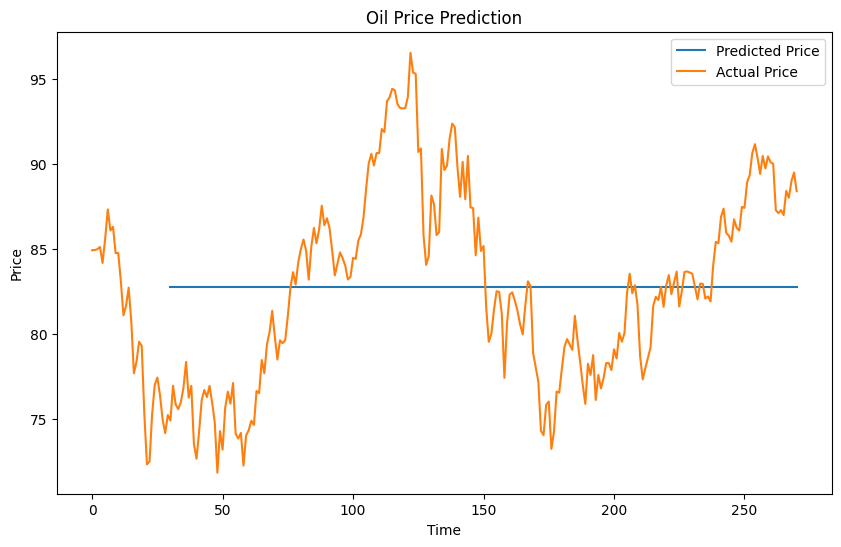

In [35]:
# Plot predictions vs actual values
seq_length = 30

plt.figure(figsize=(10, 6))

plt.plot(range(seq_length, seq_length + len(X_all_data)), X_all_data, label='Predicted Price')
plt.plot(range(len(Y_all_data)), Y_all_data, label='Actual Price')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
# plt.savefig('outputs/lstm model 01 Oil Price Prediction.png')
plt.show()

In [36]:
# Basic Transformer Model
def get_transformer_model_1(input_shape, num_heads=4, ff_dim=128, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = MultiHeadAttention(key_dim=ff_dim, num_heads=num_heads)(inputs, inputs)
    x = Dropout(dropout_rate)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [37]:
# Transformer Model with Positional Encoding
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'd_model': self.d_model,
        })
        return config

    def call(self, inputs):
        position = tf.range(tf.shape(inputs)[1], dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(tf.range(0, self.d_model, 2, dtype=tf.float32) * -(np.log(10000.0) / self.d_model))
        angle_rads = position * div_term
        sines = tf.sin(angle_rads)
        cosines = tf.cos(angle_rads)
        pos_encoding = tf.concat([sines, cosines], axis=-1)[tf.newaxis, ...]

        return inputs + pos_encoding

def get_transformer_model_2(input_shape, num_heads=4, ff_dim=128, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = PositionalEncoding(input_shape[-1])(inputs)
    x = MultiHeadAttention(key_dim=ff_dim, num_heads=num_heads)(x, x)
    x = Dropout(dropout_rate)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [38]:
# Transformer with Stacked Encoder Layers
def transformer_encoder(x, num_heads, ff_dim, dropout_rate=0.1):
    # Multi-Head Attention
    attn_output = MultiHeadAttention(key_dim=ff_dim, num_heads=num_heads)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
    
    # Feed Forward Network
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(x.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

def get_transformer_model_3(input_shape, num_heads=4, ff_dim=128, dropout_rate=0.1, num_layers=4):
    inputs = Input(shape=input_shape)
    x = PositionalEncoding(input_shape[-1])(inputs)
    for _ in range(num_layers):
        x = transformer_encoder(x, num_heads, ff_dim, dropout_rate)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [39]:
# Transformer with Attention Mechanism on Output

def get_transformer_model_4(input_shape, num_heads=4, ff_dim=128, dropout_rate=0.1, num_layers=4):
    inputs = Input(shape=input_shape)
    x = PositionalEncoding(input_shape[-1])(inputs)
    for _ in range(num_layers):
        x = transformer_encoder(x, num_heads, ff_dim, dropout_rate)
    query = Dense(128)(x)
    value = Dense(128)(x)
    attn_output = Attention()([query, value])
    attn_output = Flatten()(attn_output)
    x = Dense(100, activation='relu')(attn_output)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [40]:
models_name_list={
    'transformer_model_1' : get_transformer_model_1 ,
    'transformer_model_2' : get_transformer_model_2 ,
    'transformer_model_3' : get_transformer_model_3 ,
    'transformer_model_4' : get_transformer_model_4 
}
models_list={}

In [41]:
for model_type in models_name_list:
    print(model_type)

transformer_model_1
transformer_model_2
transformer_model_3
transformer_model_4


In [42]:
def create_model_for_each_model_type(model_type):
    for window_name in windows_dictionary:
        seq_length=windows_dictionary[window_name]
        window = windows_list[window_name]
        input_shape=(seq_length, train_df.shape[1])


        model_name=f'{model_type}_{window_name}'
        print('\n\n\n--------------',model_name, input_shape, '--------------')
        model = models_name_list[model_type](input_shape)
        print(model.summary())
        
        models_list[model_name]= {
            'model':model,
            'window':window,
            'seq_length':seq_length

        }


In [43]:
for model_type in models_name_list:
    print('\n------------',model_type,'------------')
    create_model_for_each_model_type(model_type)


------------ transformer_model_1 ------------



-------------- transformer_model_1_weekly (7, 1) --------------
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 7, 1)]               0         []                            
                                                                                                  
 multi_head_attention_4 (Mu  (None, 7, 1)                 3585      ['input_2[0][0]',             
 ltiHeadAttention)                                                   'input_2[0][0]']             
                                                                                                  
 dropout_8 (Dropout)         (None, 7, 1)                 0         ['multi_head_attention_4[0][0]
                                                                    ']       

In [44]:
models_list

{'transformer_model_1_weekly': {'model': <keras.src.engine.functional.Functional at 0x1fc058d95d0>,
  'window': Total window size: 8
  Input indices: [0 1 2 3 4 5 6]
  Label indices: [7]
  Label column name(s): ['Price'],
  'seq_length': 7},
 'transformer_model_1_bi-weekly': {'model': <keras.src.engine.functional.Functional at 0x1fc0593aad0>,
  'window': Total window size: 15
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
  Label indices: [14]
  Label column name(s): ['Price'],
  'seq_length': 14},
 'transformer_model_1_monthly': {'model': <keras.src.engine.functional.Functional at 0x1fc05960210>,
  'window': Total window size: 31
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
   24 25 26 27 28 29]
  Label indices: [30]
  Label column name(s): ['Price'],
  'seq_length': 30},
 'transformer_model_2_weekly': {'model': <keras.src.engine.functional.Functional at 0x1fbf7673c90>,
  'window': Total window size: 8
  Input indices: [0 1 2 

In [45]:
len(models_list)

12

In [46]:
for model_name in models_list:
    model = models_list[model_name]['model']
    window = models_list[model_name]['window']
    
    print('\n\n\n------------',model_name,'------------')
    history = compile_and_fit(model, window)

    histories[model_name] = history
    print('------------val performance')
    val_performance[model_name] = model.evaluate(window.val, return_dict=True)
    print('------------test performance')
    performance[model_name] = model.evaluate(window.test, verbose=1, return_dict=True)




------------ transformer_model_1_weekly ------------
Epoch 1/100
182/182 [==============================] - 2s 4ms/step - loss: 0.1662 - mean_absolute_percentage_error: 159247.0625 - mean_absolute_error: 0.3372 - val_loss: 0.0516 - val_mean_absolute_percentage_error: 52.5759 - val_mean_absolute_error: 0.2114 - lr: 0.0010
Epoch 2/100
182/182 [==============================] - 1s 3ms/step - loss: 0.1004 - mean_absolute_percentage_error: 987109.1875 - mean_absolute_error: 0.2435 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 28.0352 - val_mean_absolute_error: 0.1180 - lr: 0.0010
Epoch 3/100
182/182 [==============================] - 1s 3ms/step - loss: 0.0751 - mean_absolute_percentage_error: 1490997.7500 - mean_absolute_error: 0.2179 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 23.2338 - val_mean_absolute_error: 0.0867 - lr: 0.0010
Epoch 4/100
182/182 [==============================] - 1s 3ms/step - loss: 0.0663 - mean_absolute_percentage_error: 1814349.0000 - me

## evaluate

In [47]:
histories

{'transformer_model_1_weekly': <keras.src.callbacks.History at 0x1fc0644c810>,
 'transformer_model_1_bi-weekly': <keras.src.callbacks.History at 0x1fc0867aa10>,
 'transformer_model_1_monthly': <keras.src.callbacks.History at 0x1fc09d70c10>,
 'transformer_model_2_weekly': <keras.src.callbacks.History at 0x1fc0bb17390>,
 'transformer_model_2_bi-weekly': <keras.src.callbacks.History at 0x1fc0d3faa10>,
 'transformer_model_2_monthly': <keras.src.callbacks.History at 0x1fc0f37aa10>,
 'transformer_model_3_weekly': <keras.src.callbacks.History at 0x1fc0f545f10>,
 'transformer_model_3_bi-weekly': <keras.src.callbacks.History at 0x1fc188eaa10>,
 'transformer_model_3_monthly': <keras.src.callbacks.History at 0x1fc1ee2aa10>,
 'transformer_model_4_weekly': <keras.src.callbacks.History at 0x1fc2650da10>,
 'transformer_model_4_bi-weekly': <keras.src.callbacks.History at 0x1fc28d9df10>,
 'transformer_model_4_monthly': <keras.src.callbacks.History at 0x1fc33c9aa10>}

In [48]:
len(histories)

12

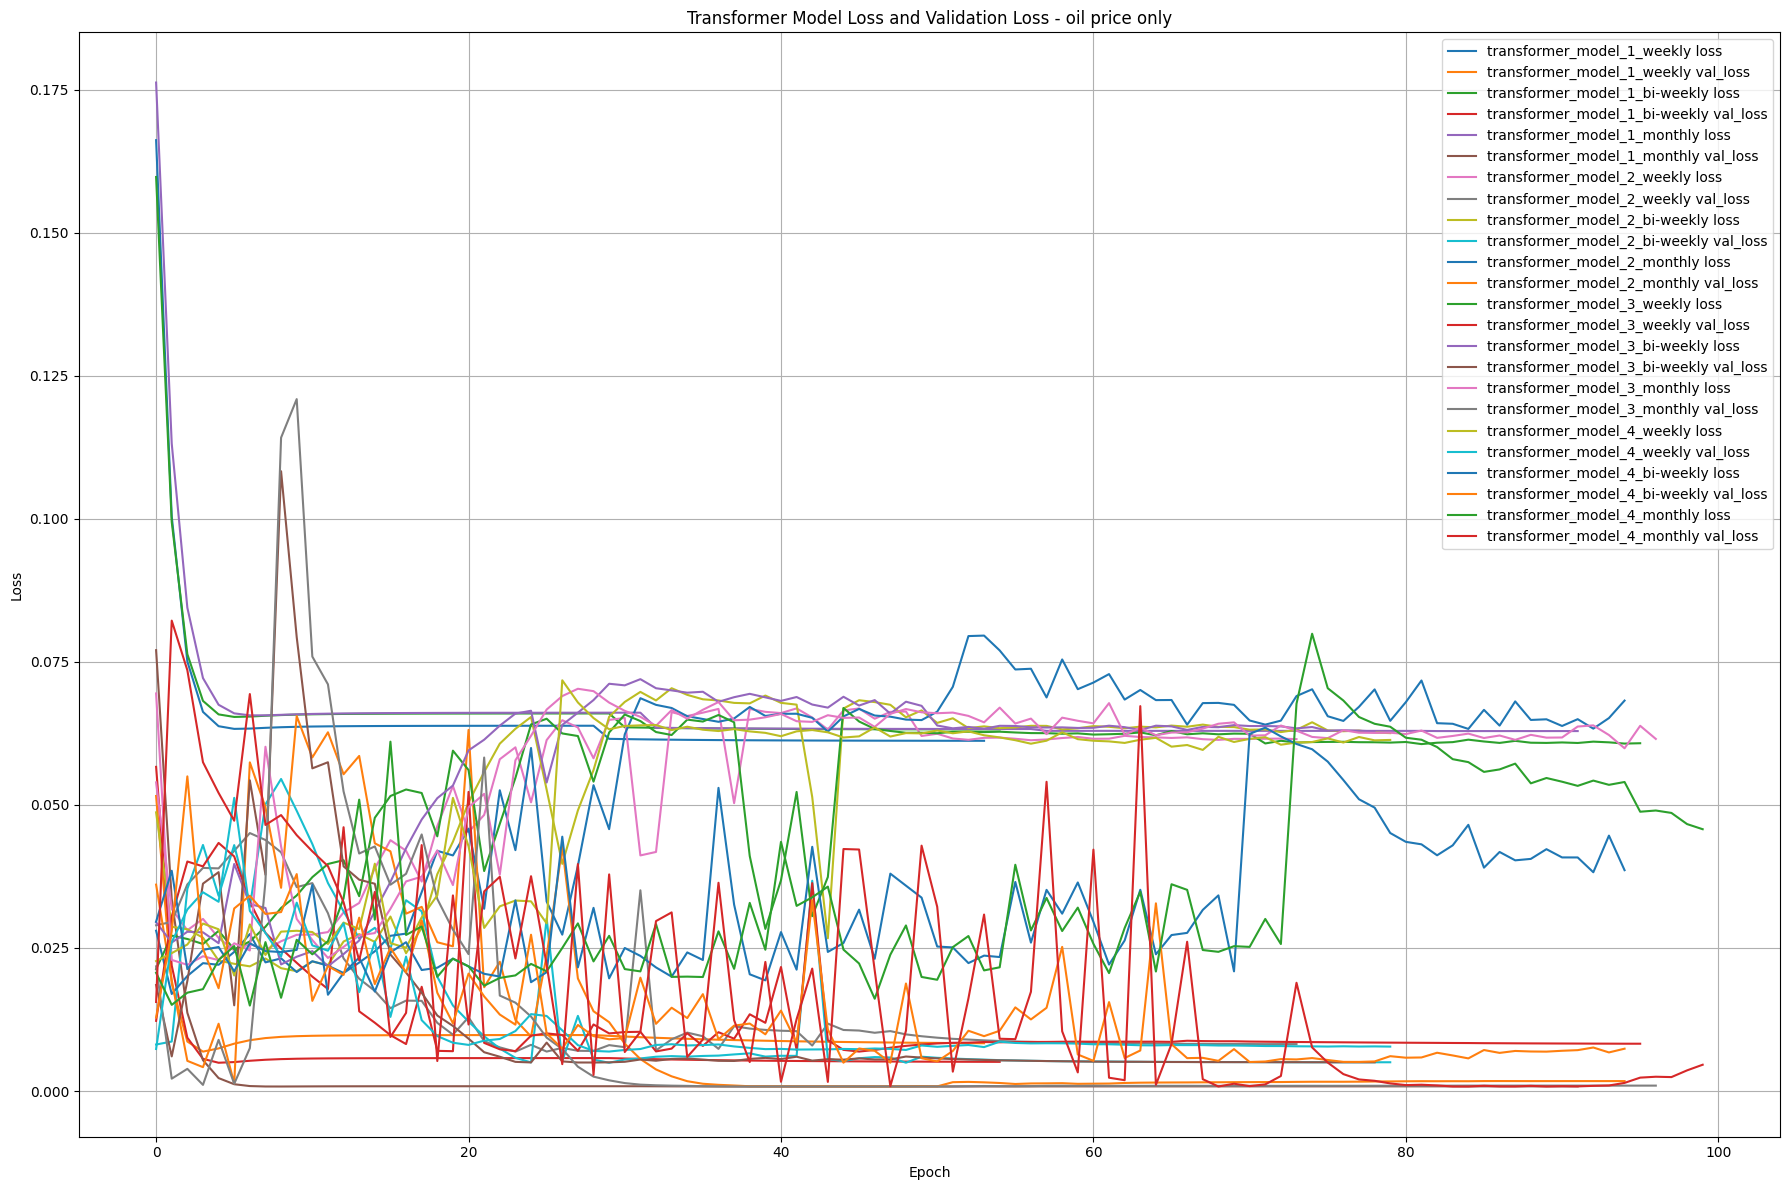

In [49]:
plt.figure(figsize=(18, 12))
for h in (histories):    # Plot Train vs Test Loss
    history=histories[h]
    plt.plot(history.history['loss'], label=f'{h} loss')
    plt.plot(history.history['val_loss'], label=f'{h} val_loss')

plt.title('Transformer Model Loss and Validation Loss - oil price only')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil/Transformer model loss all models oil price only.png')

In [50]:
val_performance

{'transformer_model_1_weekly': {'loss': 0.006883855443447828,
  'mean_absolute_percentage_error': 22.202959060668945,
  'mean_absolute_error': 0.07354433089494705},
 'transformer_model_1_bi-weekly': {'loss': 0.004937927704304457,
  'mean_absolute_percentage_error': 15.950661659240723,
  'mean_absolute_error': 0.054703179746866226},
 'transformer_model_1_monthly': {'loss': 0.0007827205117791891,
  'mean_absolute_percentage_error': 5.436278343200684,
  'mean_absolute_error': 0.023815326392650604},
 'transformer_model_2_weekly': {'loss': 0.006883890833705664,
  'mean_absolute_percentage_error': 22.17631721496582,
  'mean_absolute_error': 0.07320503145456314},
 'transformer_model_2_bi-weekly': {'loss': 0.004932371899485588,
  'mean_absolute_percentage_error': 15.86510181427002,
  'mean_absolute_error': 0.054073262959718704},
 'transformer_model_2_monthly': {'loss': 0.0007960640359669924,
  'mean_absolute_percentage_error': 5.561276912689209,
  'mean_absolute_error': 0.024577045813202858},


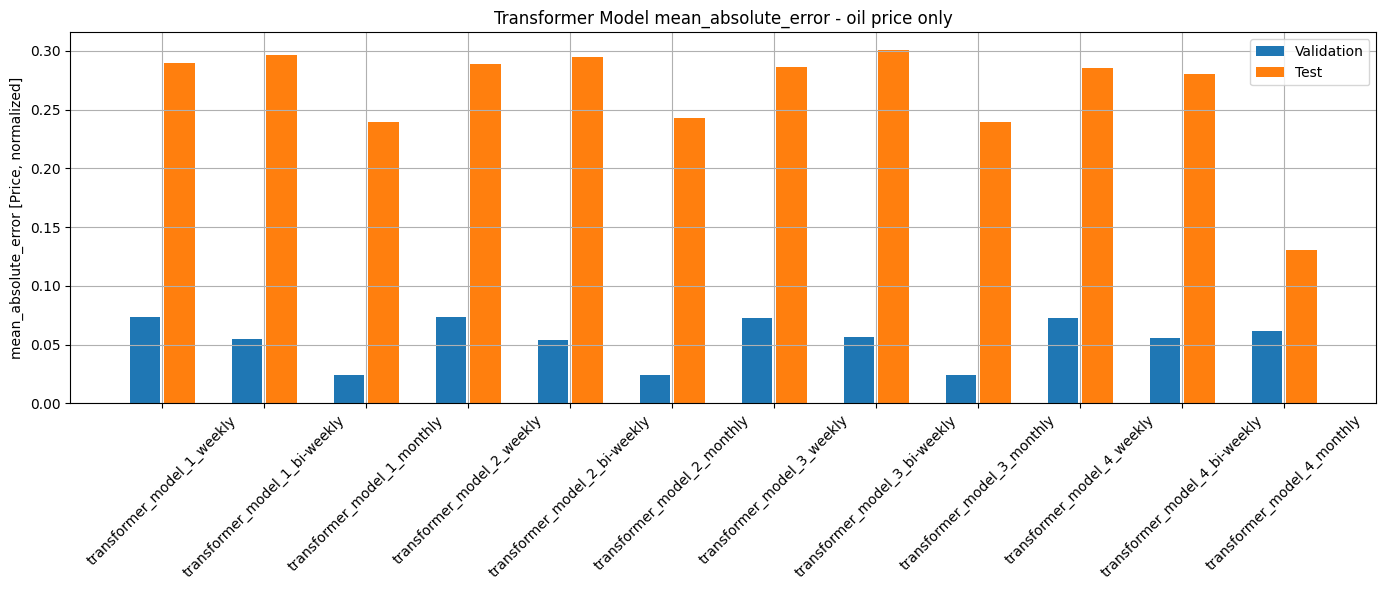

In [51]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.figure(figsize=(14, 6))
plt.title('Transformer Model mean_absolute_error - oil price only')
plt.ylabel('mean_absolute_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil/Transformer mean_absolute_error all models oil price only.png')


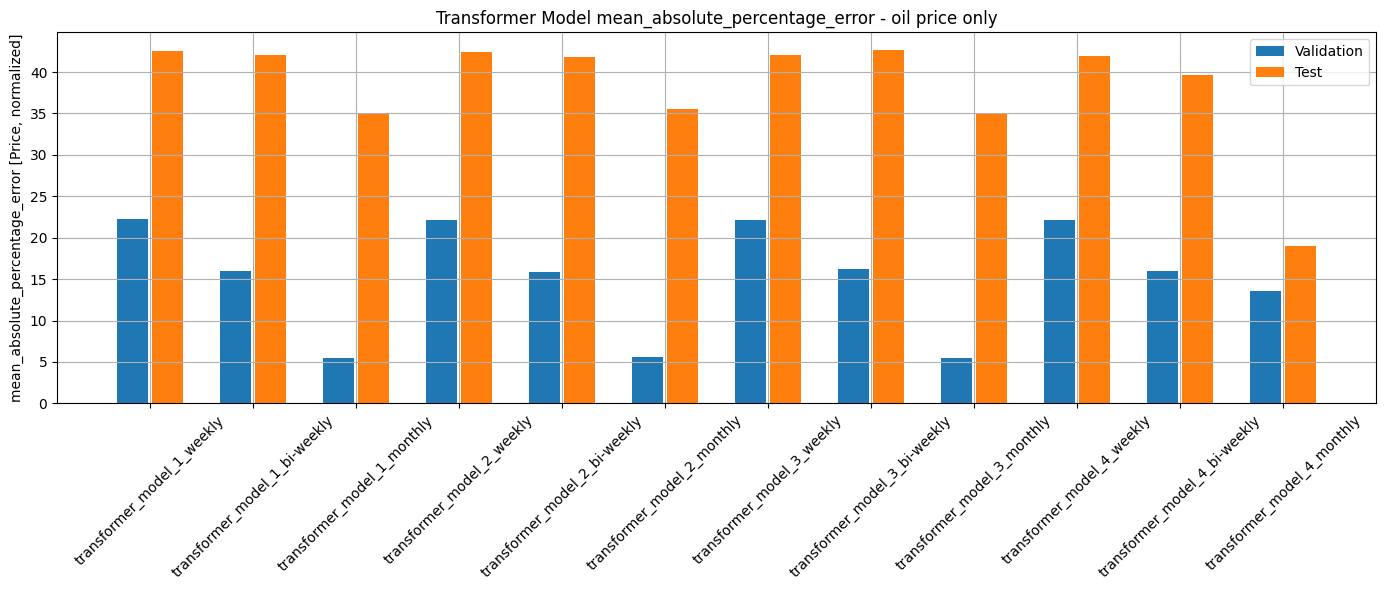

In [52]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_percentage_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]
plt.figure(figsize=(14, 6))
plt.title('Transformer Model mean_absolute_percentage_error - oil price only')
plt.ylabel('mean_absolute_percentage_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil/Transformer mean_absolute_percentage_error all models oil price only.png')

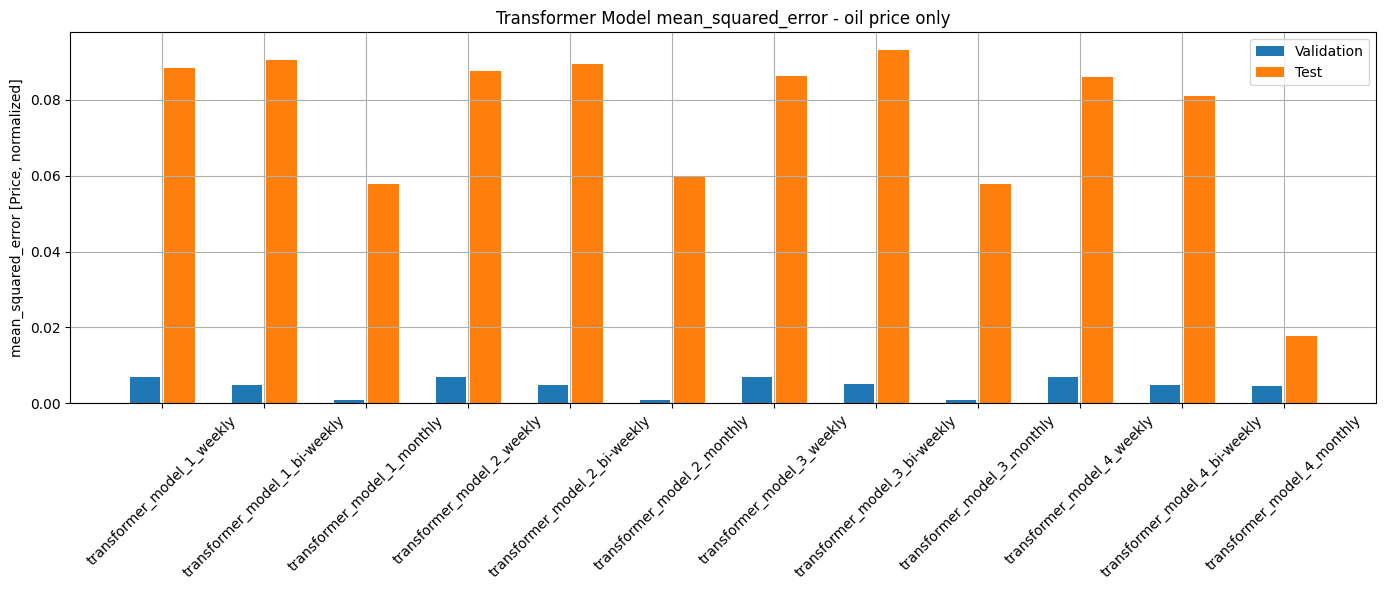

In [53]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error '
val_mae = [v['loss'] for v in val_performance.values()]
test_mae = [v['loss'] for v in performance.values()]
plt.figure(figsize=(14, 6))
plt.title('Transformer Model mean_squared_error - oil price only')
plt.ylabel('mean_squared_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil/Transformer mean_squared_error all models oil price only.png')

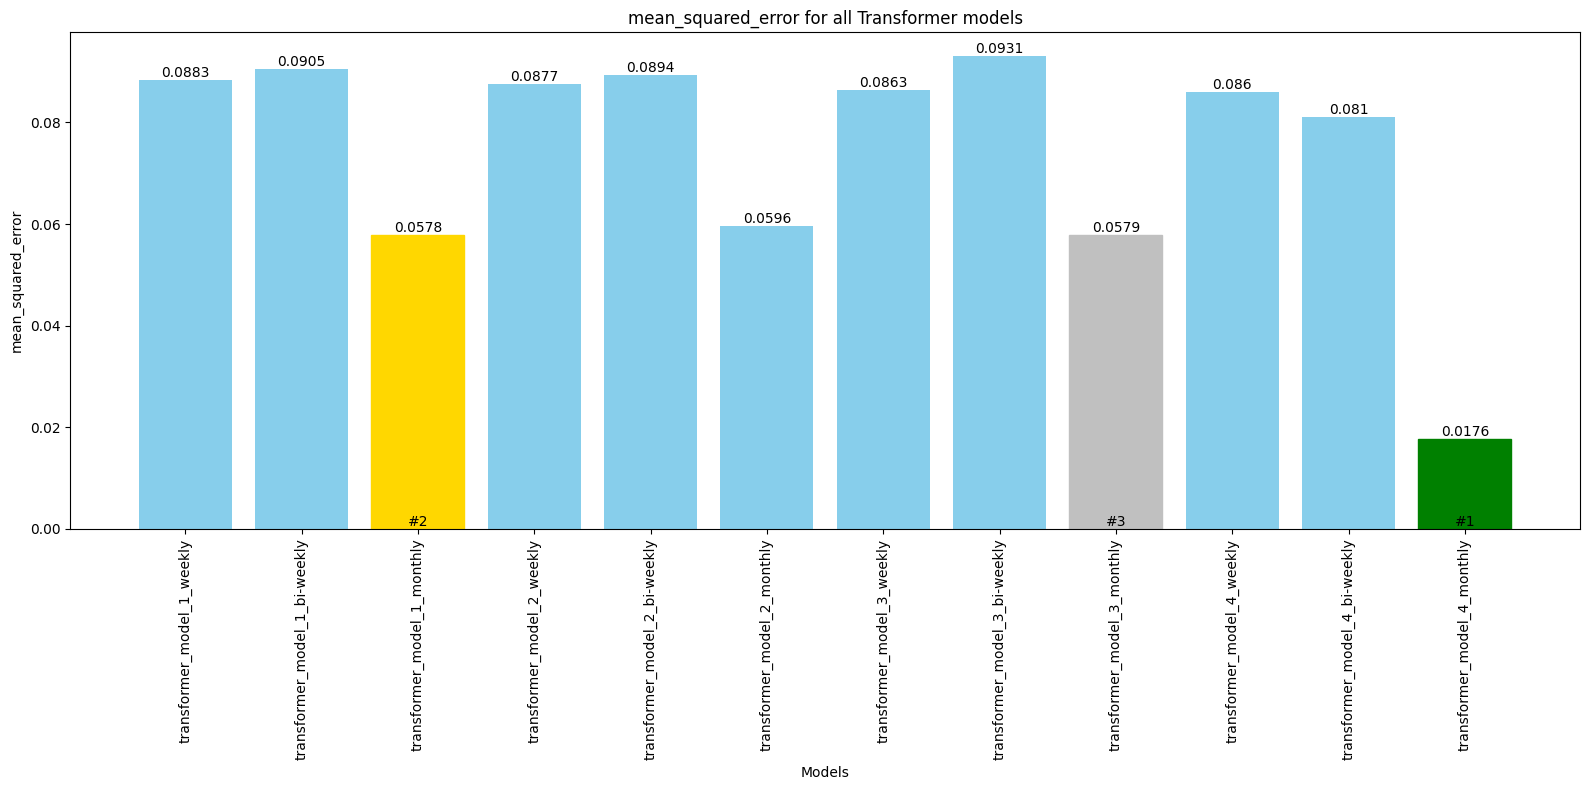

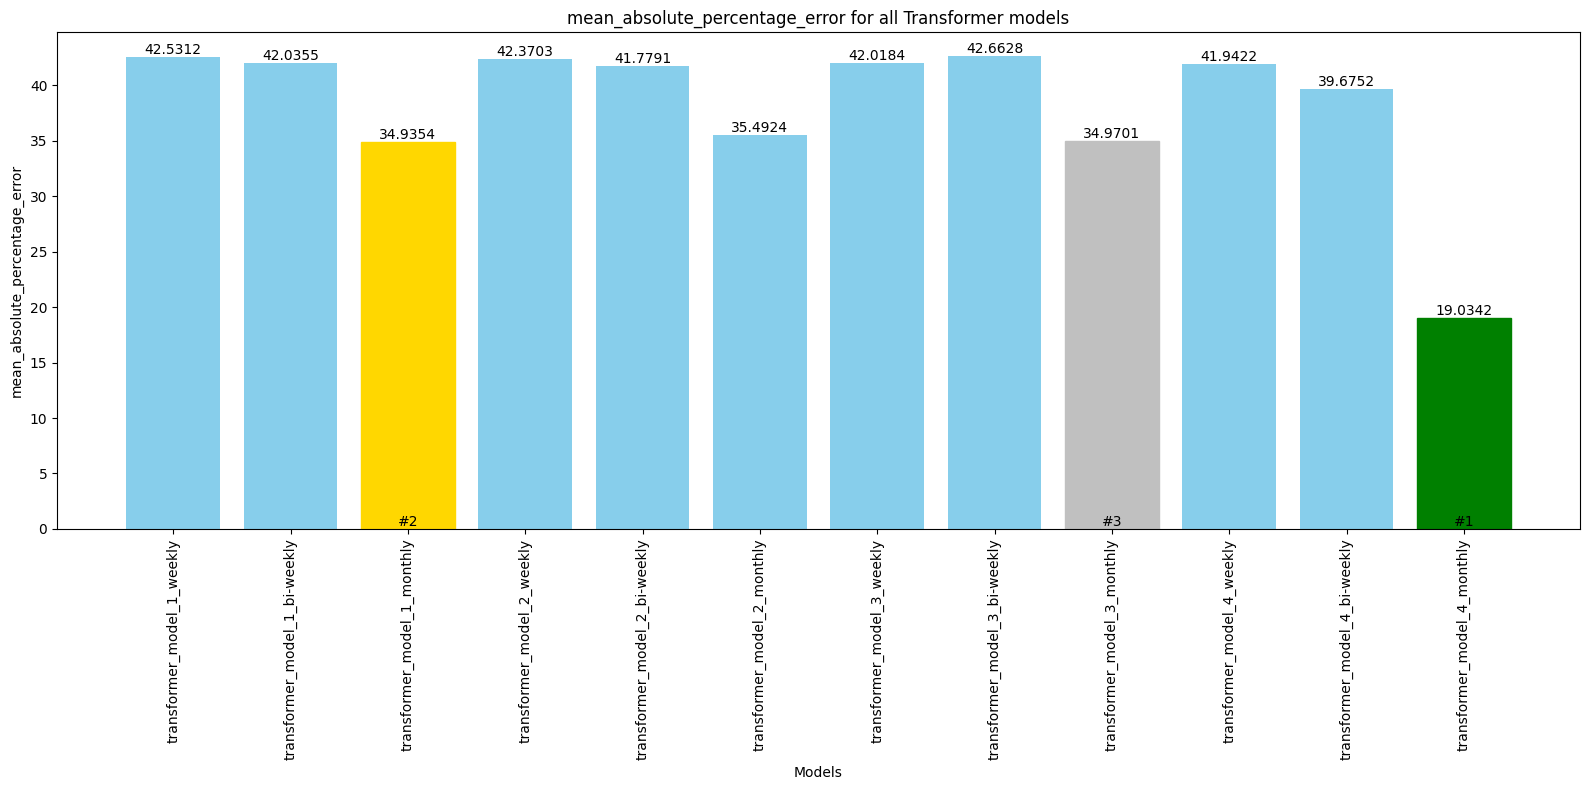

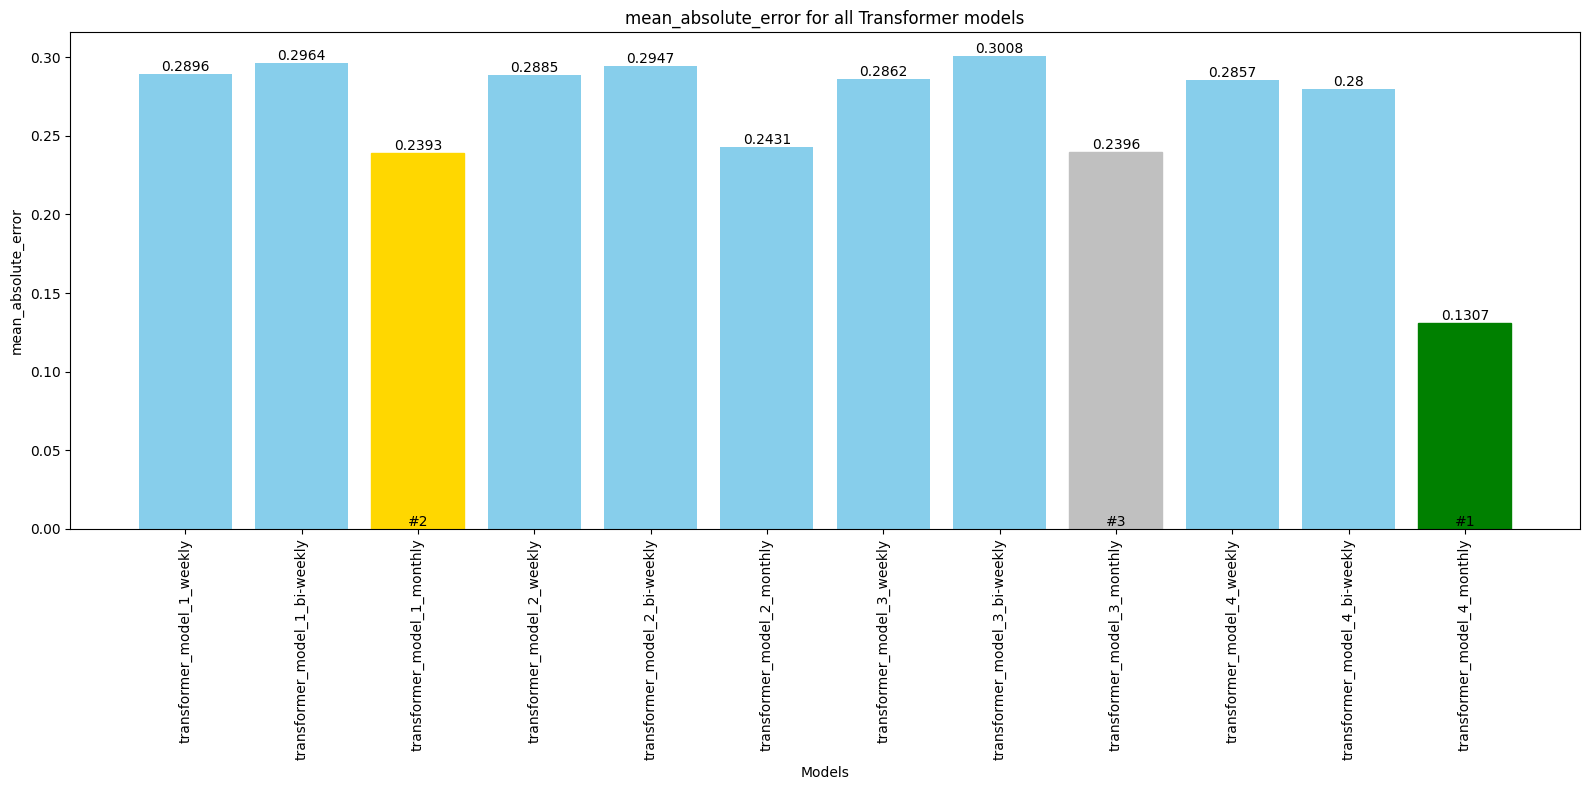

Top 3 models with minimum mean_squared_error: ['transformer_model_4_monthly', 'transformer_model_1_monthly', 'transformer_model_3_monthly']
Top 3 models with minimum mean_absolute_percentage_error: ['transformer_model_4_monthly', 'transformer_model_1_monthly', 'transformer_model_3_monthly']
Top 3 models with minimum mean_absolute_error: ['transformer_model_4_monthly', 'transformer_model_1_monthly', 'transformer_model_3_monthly']


In [54]:
# Extract data for each metric
models = list(performance.keys())
loss_values = [performance[model]['loss'] for model in models]
mae_values = [performance[model]['mean_absolute_percentage_error'] for model in models]
mse_values = [performance[model]['mean_absolute_error'] for model in models]

# Function to plot and save a metric, highlighting the best model
def plot_and_save_metric(metric_values, metric_name, best_models_indices):
    plt.figure(figsize=(16, 8))
    bars = plt.bar(models, metric_values, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for all Transformer models')
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Highlight the best models with different colors
    colors = ['green', 'gold', 'silver']
    for rank, index in enumerate(best_models_indices):
        bars[index].set_color(colors[rank])
        yval = bars[index].get_height()

        plt.text(bars[index].get_x() + bars[index].get_width()/2,  0, f'#{rank+1}', ha='center', va='bottom')

    # Annotate all bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

    plt.savefig(f'outputs/oil/Transformer {metric_name}_comparison.png')
    plt.show()

# Find the indices of the top 3 models with the minimum values for each metric
top_n = 3

min_loss_indices = np.argsort(loss_values)[:top_n]
min_mae_indices = np.argsort(mae_values)[:top_n]
min_mse_indices = np.argsort(mse_values)[:top_n]
# Plot and save loss
plot_and_save_metric(loss_values, 'mean_squared_error', min_loss_indices)

# Plot and save mean_absolute_error
plot_and_save_metric(mae_values, 'mean_absolute_percentage_error', min_mae_indices)

# Plot and save mean_squared_error
plot_and_save_metric(mse_values, 'mean_absolute_error', min_mse_indices)

# Get the model names for the top 3 models
min_loss_models = [models[i] for i in min_loss_indices]
min_mae_models = [models[i] for i in min_mae_indices]
min_mse_models = [models[i] for i in min_mse_indices]

print(f'Top {top_n} models with minimum mean_squared_error: {min_loss_models}')
print(f'Top {top_n} models with minimum mean_absolute_percentage_error: {min_mae_models}')
print(f'Top {top_n} models with minimum mean_absolute_error: {min_mse_models}')

In [55]:
model_name='transformer_model_4_monthly' 
model = models_list[model_name]['model']
window = models_list[model_name]['window']
seq_length = models_list[model_name]['seq_length']

In [56]:
window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [89]:
seq_length

30

In [57]:
all_predict = model.predict(window.all_data)
print(all_predict.shape)

241/241 [==============================] - 2s 5ms/step
(241, 1)


In [58]:
all_predict[0]

array([0.38243192], dtype=float32)

264/264 [==============================] - 1s 1ms/step


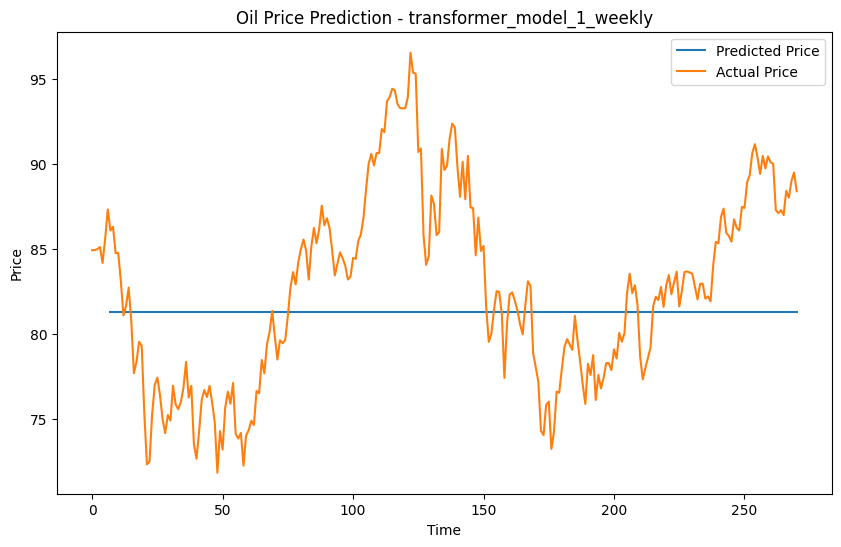

257/257 [==============================] - 1s 2ms/step


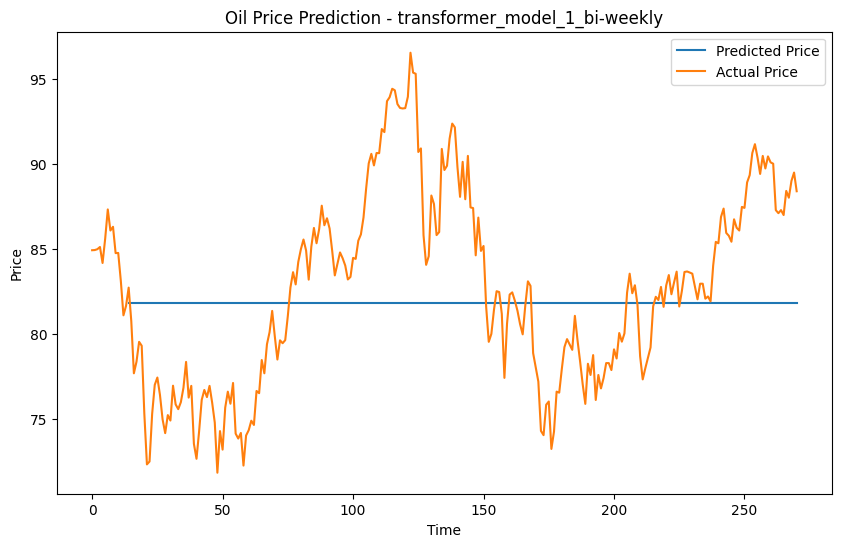

241/241 [==============================] - 1s 3ms/step


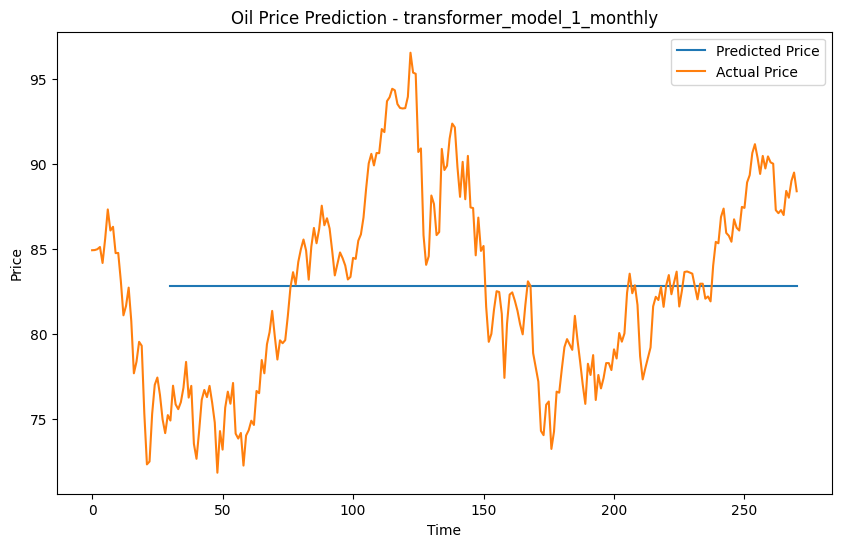

264/264 [==============================] - 1s 2ms/step


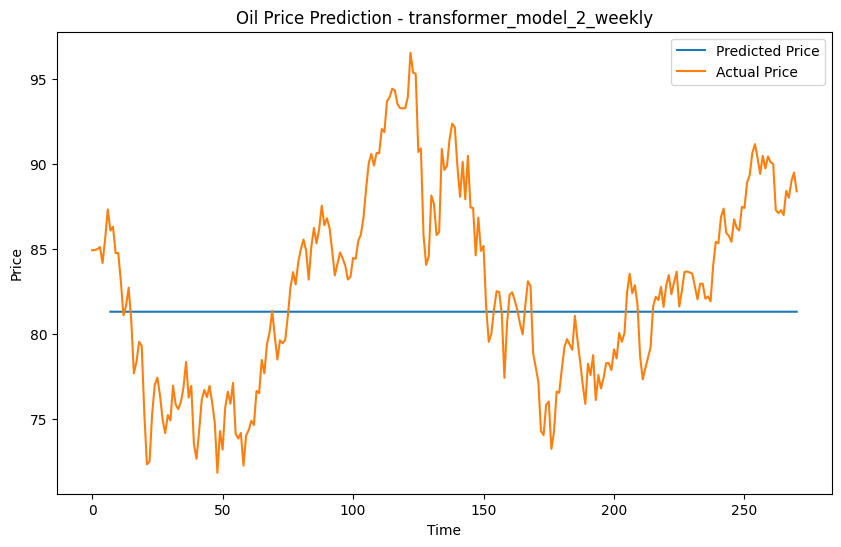

257/257 [==============================] - 1s 2ms/step


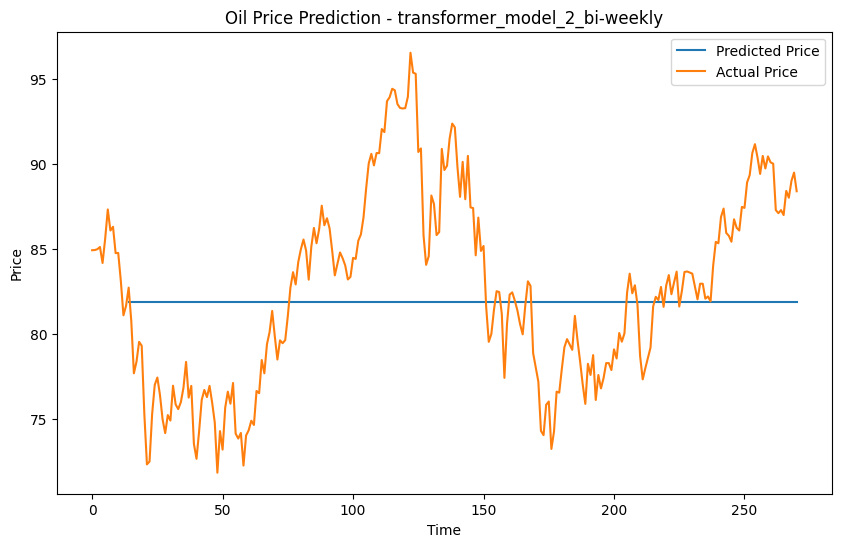

241/241 [==============================] - 1s 2ms/step


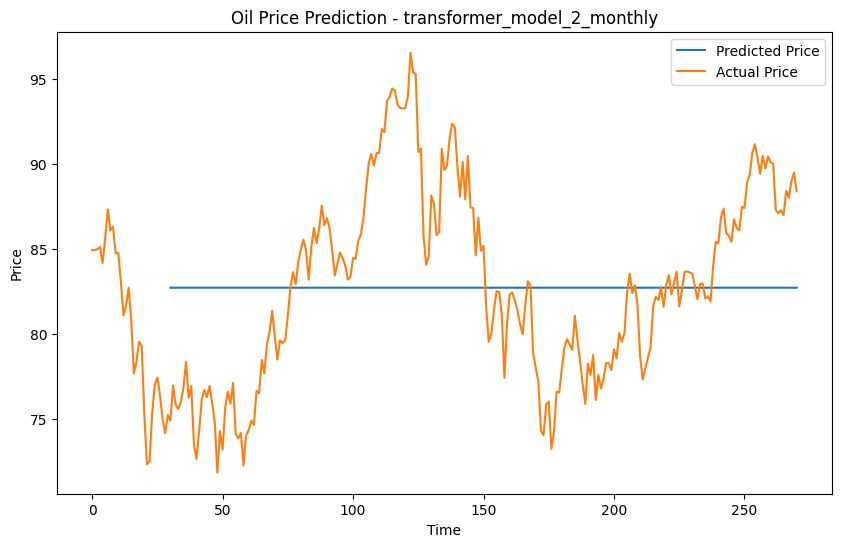

264/264 [==============================] - 2s 4ms/step


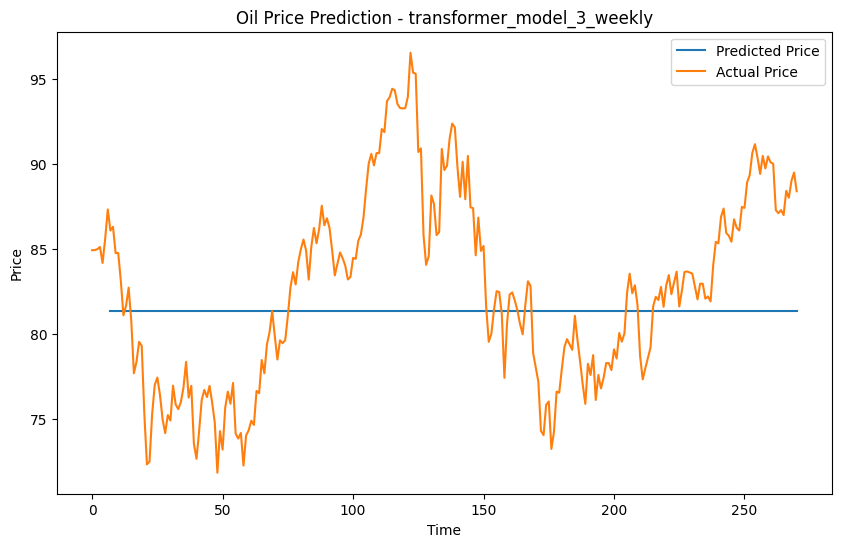

257/257 [==============================] - 2s 4ms/step


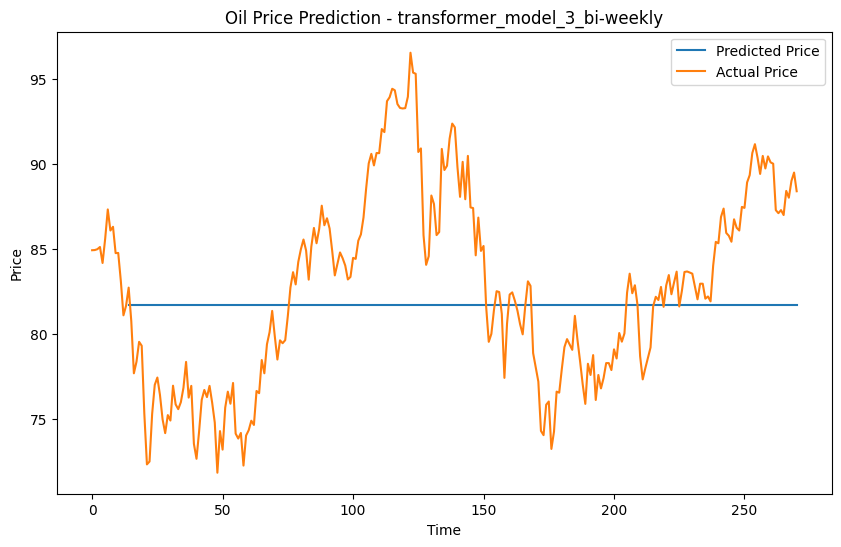

241/241 [==============================] - 2s 5ms/step


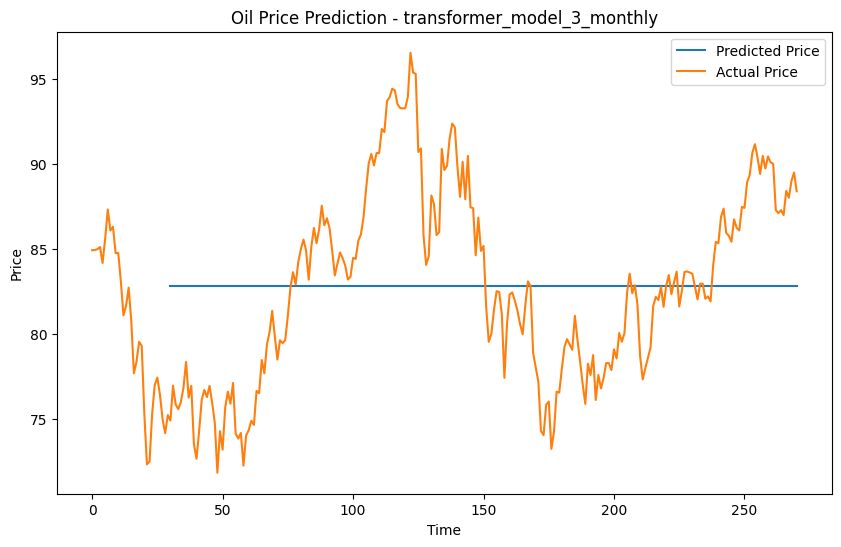

264/264 [==============================] - 2s 4ms/step


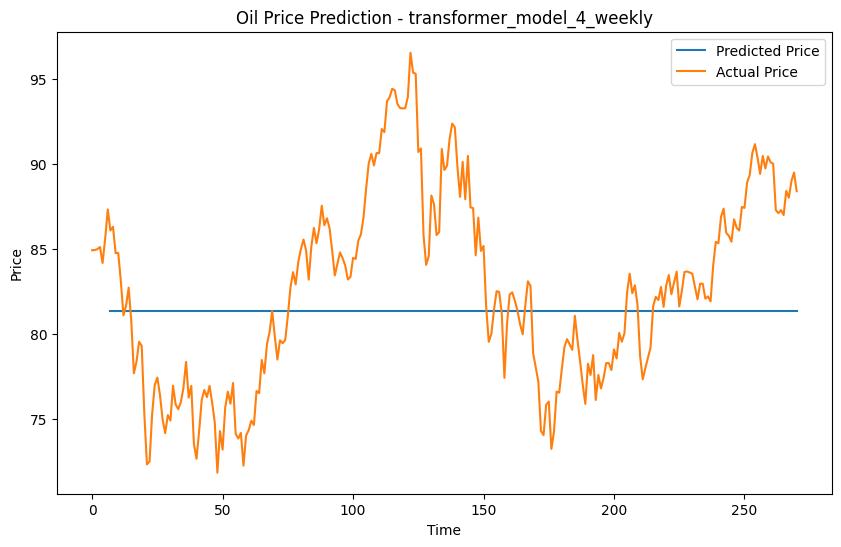

257/257 [==============================] - 2s 4ms/step


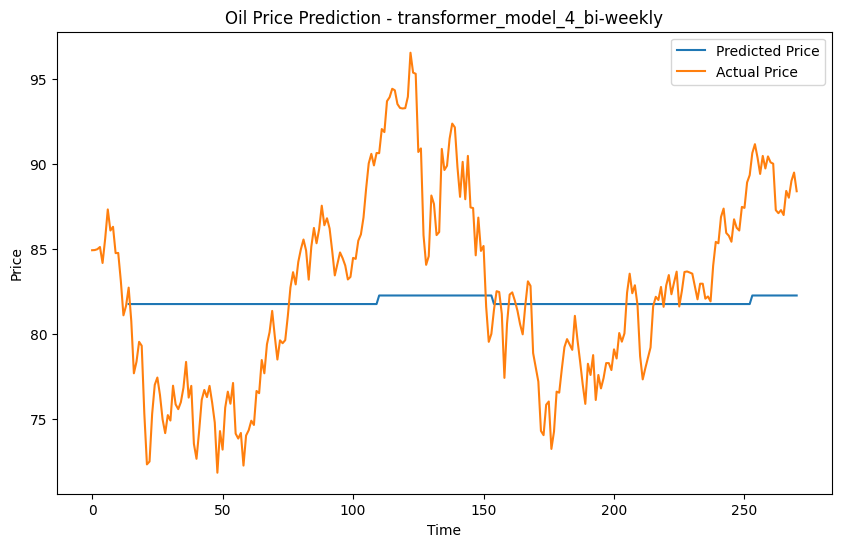

241/241 [==============================] - 1s 5ms/step


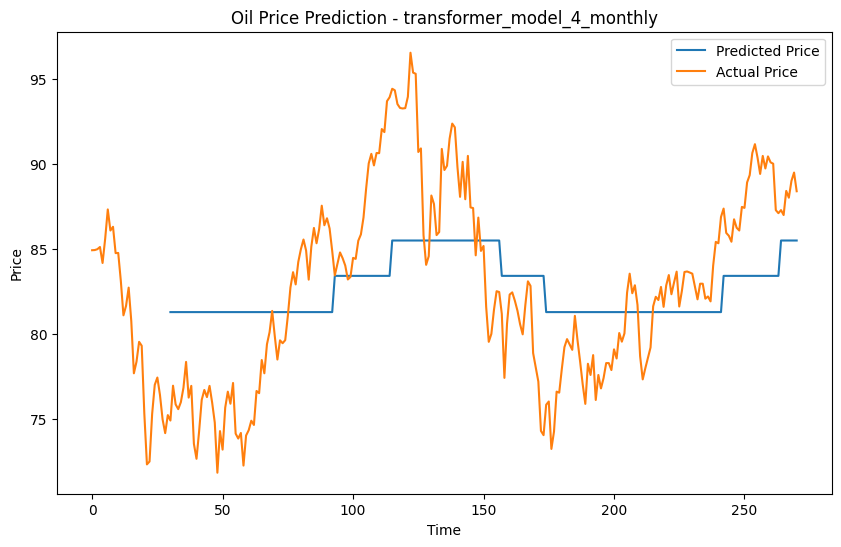

In [59]:
# Plot predictions vs actual values

# Y_test = np.array([s[1][0][0][0].numpy() for s in iter(window.test)])
Y_all_data = oil_data['Price'].values
Y_all_data = scaler.inverse_transform(Y_all_data.reshape(-1, 1))

for model_name in models_list:
    model = models_list[model_name]['model']
    window = models_list[model_name]['window']
    seq_length = models_list[model_name]['seq_length']

    all_predict = model.predict(window.all_data)
    try:

        X_all_data = scaler.inverse_transform(all_predict)

        plt.figure(figsize=(10, 6))
        plt.plot(range(seq_length, seq_length + len(X_all_data)), X_all_data, label='Predicted Price')
        plt.plot(range(len(Y_all_data)), Y_all_data, label='Actual Price')
        plt.title(f'Oil Price Prediction - {model_name}')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.savefig(f'outputs/oil/Transformer {model_name} Oil Price Prediction.png')
        plt.show()
    except:
        print("Error", model_name, all_predict.shape)